In [60]:
import torch
import triton
import triton.language as tl

@triton.jit
def kmeans_assign_kernel(
    X_ptr, centroids_ptr, assignments_ptr,
    B, H, L, C, D: tl.constexpr,
    stride_x_b, stride_x_h, stride_x_l, stride_x_d,
    stride_c_b, stride_c_h, stride_c_c, stride_c_d,
    stride_a_b, stride_a_h, stride_a_l,
    BLOCK_SIZE_L: tl.constexpr,
    BLOCK_SIZE_C: tl.constexpr
):
    """
    Kernel to assign each point to the closest centroid.
    """
    b_idx = tl.program_id(0)
    h_idx = tl.program_id(1)
    l_idx = tl.program_id(2) * BLOCK_SIZE_L + tl.arange(0, BLOCK_SIZE_L)

    x_offset = b_idx * stride_x_b + h_idx * stride_x_h + l_idx * stride_x_l
    c_offset = b_idx * stride_c_b + h_idx * stride_c_h

    # Load input points
    x = tl.load(X_ptr + x_offset[:, None] + tl.arange(0, D) * stride_x_d, mask=l_idx[:, None] < L, other=0.0)

    # Track closest cluster
    min_dist = tl.full([BLOCK_SIZE_L], 1e30, dtype=tl.float32)
    best_cluster = tl.zeros([BLOCK_SIZE_L], dtype=tl.int32)

    for c in range(0, C, BLOCK_SIZE_C):
        c_idx = c + tl.arange(0, BLOCK_SIZE_C)

        # Load centroids
        centroids = tl.load(
            centroids_ptr + c_offset + c_idx[:, None] * stride_c_c + tl.arange(0, D) * stride_c_d,
            mask=c_idx[:, None] < C,
            other=0.0
        )

        # Compute squared Euclidean distance
        diff = x[:, None] - centroids[None, :]
        dists = tl.sum(diff * diff, axis=-1)

         # Find the closest cluster in the current batch
        local_min_dist, local_best_cluster = tl.min(dists, axis=-1, return_indices=True)
    
        # Update global minimum distance and best cluster if local one is better
        closer = local_min_dist < min_dist
        min_dist = tl.where(closer, local_min_dist, min_dist)
        best_cluster = tl.where(closer, c + local_best_cluster, best_cluster)  # add c to convert local cluster index to global


    # Store assignments
    tl.store(
        assignments_ptr + b_idx * stride_a_b + h_idx * stride_a_h + l_idx * stride_a_l, best_cluster, 
        mask=l_idx < L
    )

@triton.jit
def kmeans_update_kernel(
    X_ptr, new_centroids_ptr, cluster_counts_ptr, assignments_ptr,
    B, H, L, C, D: tl.constexpr,
    stride_x_b, stride_x_h, stride_x_l, stride_x_d,
    stride_nc_b, stride_nc_h, stride_nc_c, stride_nc_d,
    stride_cc_b, stride_cc_h, stride_cc_c,
    stride_a_b, stride_a_h, stride_a_l,
    BLOCK_SIZE_L: tl.constexpr,
    BLOCK_SIZE_C: tl.constexpr
):
    """
    Kernel to compute new centroids based on the assignments, handling multiple centroids at once.
    """
    b_idx = tl.program_id(0)
    h_idx = tl.program_id(1)
    c_start = tl.program_id(2) * BLOCK_SIZE_C
    c_idx = c_start + tl.arange(0, BLOCK_SIZE_C)

    mask_c = c_idx < C  # Mask for valid centroids
    sum_x = tl.zeros([BLOCK_SIZE_C, D], dtype=tl.float32)
    count = tl.zeros([BLOCK_SIZE_C], dtype=tl.float32)

    for l in range(0, L, BLOCK_SIZE_L):
        l_idx = l + tl.arange(0, BLOCK_SIZE_L)
        mask_l = l_idx < L

        # Load assignments
        cluster = tl.load(
            assignments_ptr + b_idx * stride_a_b + h_idx * stride_a_h + l_idx * stride_a_l, 
            mask=mask_l, other=-1
        )

        # Load points
        x = tl.load(
            X_ptr + b_idx * stride_x_b + h_idx * stride_x_h + l_idx[:, None] * stride_x_l + tl.arange(0, D) * stride_x_d,
            mask=mask_l[:, None], 
            other=0.0
        )

        # Compute cluster membership for all centroids in the current block
        belongs_to_cluster = (cluster[:, None] == c_idx[None, :]).to(tl.float32)
        sum_x += tl.sum(x[:, None, :] * belongs_to_cluster[:, :, None], axis=0)
        count += tl.sum(belongs_to_cluster, axis=0)

    # Store new centroids
    tl.store(
        new_centroids_ptr + b_idx * stride_nc_b + h_idx * stride_nc_h + c_idx[:, None] * stride_nc_c + tl.arange(0, D) * stride_nc_d,
        sum_x, 
        mask=mask_c[:, None]
    )
    tl.store(
        cluster_counts_ptr + b_idx * stride_cc_b + h_idx * stride_cc_h + c_idx * stride_cc_c,
        count, 
        mask=mask_c
    )

def kmeans_triton(X, num_clusters, num_iters=10):
    """
    X: Tensor of shape (B, H, L, D)
    num_clusters: Number of clusters C
    Returns: centroids of shape (B, H, C, D)
    """
    B, H, L, D = X.shape
    C = num_clusters
    device = X.device
    
    X = X.contiguous()
    
    # Initialize centroids
    shuffled_indices = torch.rand(B, H, L, device=device).argsort(dim=-1)
    indices = shuffled_indices[:, :, :C]
    centroids = torch.gather(X, 2, indices.unsqueeze(-1).expand(-1, -1, -1, D)).clone()

    assignments = torch.zeros((B, H, L), dtype=torch.int32, device=device)
    new_centroids = torch.zeros((B, H, C, D), device=device)
    cluster_counts = torch.zeros((B, H, C), device=device)

    BLOCK_SIZE_L = min(64, L)
    grid_assign = (B, H, triton.cdiv(L, BLOCK_SIZE_L))
    BLOCK_SIZE_C = min(32, C)  # Number of centroids processed in parallel
    grid_update = (B, H, triton.cdiv(C, BLOCK_SIZE_C))

    for _ in range(num_iters):
        new_centroids.zero_()
        cluster_counts.zero_()

        # Assign points
        kmeans_assign_kernel[grid_assign](
            X, centroids, assignments,
            B, H, L, C, D,
            X.stride(0), X.stride(1), X.stride(2), X.stride(3),
            centroids.stride(0), centroids.stride(1), centroids.stride(2), centroids.stride(3),
            assignments.stride(0), assignments.stride(1), assignments.stride(2),
            BLOCK_SIZE_L=64, BLOCK_SIZE_C=32
        )
        
        # Update centroids
        kmeans_update_kernel[grid_update](
            X, new_centroids, cluster_counts, assignments,
            B, H, L, C, D,
            X.stride(0), X.stride(1), X.stride(2), X.stride(3),
            new_centroids.stride(0), new_centroids.stride(1), new_centroids.stride(2), new_centroids.stride(3),
            cluster_counts.stride(0), cluster_counts.stride(1), cluster_counts.stride(2),
            assignments.stride(0), assignments.stride(1), assignments.stride(2),
            BLOCK_SIZE_L=64, BLOCK_SIZE_C=32
        )

        # Reset empty clusters
        empty_clusters = cluster_counts == 0
        if empty_clusters.any():
            new_samples = torch.randint(0, L, (B, H, num_clusters), device=device)
            new_centroids[empty_clusters] = X[torch.arange(B)[:, None, None], 
                                              torch.arange(H)[None, :, None], 
                                              new_samples][empty_clusters]

        centroids = new_centroids / cluster_counts.clamp(min=1).unsqueeze(-1)
    
    return centroids, cluster_counts


In [20]:
import torch

@torch.compile()
@torch.no_grad()
def kmeans_pytorch(X, num_clusters, num_iters=1):
    """
    X: Tensor of shape (B, H, L, D)
    num_clusters: Number of clusters C
    Returns: centroids of shape (B, H, C, D)
    """
    B, H, L, D = X.shape
    C = num_clusters
    device = X.device

    X = X.contiguous()

    # Initialize centroids by selecting random points
    shuffled_indices = torch.rand(B, H, L, device=device).argsort(dim=-1)
    indices = shuffled_indices[:, :, :C]
    centroids = torch.gather(X, 2, indices.unsqueeze(-1).expand(-1, -1, -1, D)).clone()

    assignments = torch.zeros((B, H, L), dtype=torch.int64, device=device)
    new_centroids = torch.zeros((B, H, C, D), device=device)
    cluster_counts = torch.zeros((B, H, C), device=device)

    for _ in range(num_iters):
        # Compute distances & assign clusters
        distances = torch.cdist(X, centroids)  # Shape: (B, H, L, C)
        assignments = torch.argmin(distances, dim=-1)  # Shape: (B, H, L)

        # Compute new centroids using vectorized operations
        one_hot_assignments = torch.nn.functional.one_hot(assignments, num_clusters).to(X.dtype)  # (B, H, L, C)
        new_centroids = torch.einsum('bhld,bhlc->bhcd', X, one_hot_assignments) / one_hot_assignments.sum(dim=2).clamp(min=1).unsqueeze(-1)

        # Reset empty clusters
        empty_clusters = one_hot_assignments.sum(dim=2) == 0
        if empty_clusters.any():
            new_samples = torch.randint(0, L, (B, H, num_clusters), device=device)
            new_centroids[empty_clusters] = X[torch.arange(B)[:, None, None], 
                                              torch.arange(H)[None, :, None], 
                                              new_samples][empty_clusters]

        centroids = new_centroids.clone()  # Update centroids

    return centroids, assignments


In [23]:
import time

B, H, L, D, C = 1, 8, 1000, 128, 100  # Batch, Heads, Points, Features, Clusters

data = []

for L in [100, 500, 1000, 10000, 100000]:
    for reduction in [2, 5, 10, 20]:
        for _ in range(10):
            C = L // reduction
            X = torch.randn(B, H, L, D, device="cuda")
    
            torch.cuda.synchronize()
            start = time.time()
    
            kmeans_pytorch(X, C, num_iters=10)
    
            torch.cuda.synchronize()
            data.append({'time': time.time() - start, 'L': L, 'reduction': reduction})

OutOfMemoryError: CUDA out of memory. Tried to allocate 149.01 GiB. GPU 0 has a total capacity of 79.10 GiB of which 75.38 GiB is free. Process 1381323 has 3.70 GiB memory in use. Of the allocated memory 1.39 GiB is allocated by PyTorch, and 1.65 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

<Axes: xlabel='L', ylabel='time'>

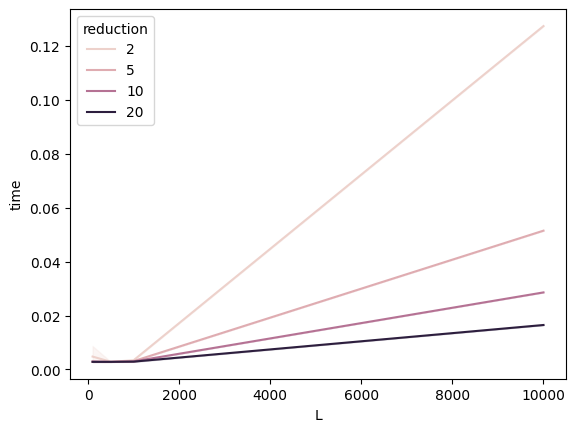

In [22]:
import seaborn
import pandas as pd
seaborn.lineplot(pd.DataFrame(data), x='L', y='time', hue='reduction')

In [56]:
import torch
import time

def check_correctness(triton_fn, pytorch_fn, X, num_clusters, num_iters=10, tolerance=1e-4):
    """
    Compares the outputs of the Triton and PyTorch k-means implementations.

    triton_fn: Triton-based k-means function
    pytorch_fn: PyTorch-based k-means function
    X: Input tensor of shape (B, H, L, D)
    num_clusters: Number of clusters
    num_iters: Number of k-means iterations
    tolerance: Acceptable error threshold for centroid comparison
    """
    torch.manual_seed(42)  # Set seed for reproducibility
    centroids_t, counts_t = triton_fn(X, num_clusters, num_iters)
    
    torch.manual_seed(42)  # Reset seed for PyTorch for fair comparison
    centroids_p, counts_p = pytorch_fn(X, num_clusters, num_iters)

    # Check if centroids are close enough
    centroid_diff = torch.norm(centroids_t - centroids_p) / torch.norm(centroids_p)
    centroids_match = centroid_diff < tolerance
    
    # Check if cluster counts match
    counts_match = torch.allclose(counts_t.float(), counts_p.float(), atol=tolerance)
    
    return centroids_match, counts_match, centroid_diff.item()


def benchmark_kmeans(triton_fn, pytorch_fn, X, num_clusters, num_iters=10, runs=5):
    """
    Benchmarks the performance of Triton vs PyTorch k-means implementations.

    triton_fn: Triton-based k-means function
    pytorch_fn: PyTorch-based k-means function
    X: Input tensor of shape (B, H, L, D)
    num_clusters: Number of clusters
    num_iters: Number of k-means iterations
    runs: Number of runs for averaging execution time
    """
    torch.cuda.synchronize()
    triton_times = []
    pytorch_times = []

    for _ in range(runs):
        # Triton timing
        start = time.time()
        triton_fn(X, num_clusters, num_iters)
        torch.cuda.synchronize()
        triton_times.append(time.time() - start)

        # PyTorch timing
        start = time.time()
        pytorch_fn(X, num_clusters, num_iters)
        torch.cuda.synchronize()
        pytorch_times.append(time.time() - start)

    triton_avg = sum(triton_times) / runs
    pytorch_avg = sum(pytorch_times) / runs
    speedup = pytorch_avg / triton_avg

    return triton_avg, pytorch_avg, speedup

# Example input tensor
B, H, L, D, C = 1, 8, 1000, 128, 100  # Batch, Heads, Points, Features, Clusters
X = torch.randn(B, H, L, D, device="cuda")


In [57]:
# Run correctness check
correctness_result = check_correctness(kmeans_triton, kmeans_pytorch, X, C)
correctness_result

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,


RuntimeError: The size of tensor a (100) must match the size of tensor b (1000) at non-singleton dimension 2

In [11]:
# Run benchmark
benchmark_result = benchmark_kmeans(kmeans_triton, kmeans_pytorch, X, C)
benchmark_result

(0.08821172714233398, 0.07337899208068847, 0.8318507579189311)

In [38]:
!pip install scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 107.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.6/37.6 MB 115.2 MB/s eta 0:00:00 MB/s eta 0:00:01


tensor([[[17.,  2., 15.]]], device='cuda:0')
tensor([[[2, 1, 0, 3, 2, 2, 2, 2, 0, 3, 0, 0, 0, 2, 0, 2, 3, 3, 0, 2, 0, 3, 2,
          3, 1, 3, 2, 0, 3, 0, 3, 0, 0, 2, 0, 3, 3, 0, 0, 3, 3, 2, 3, 2, 2, 3,
          2, 3, 0, 0]]], device='cuda:0', dtype=torch.int32)
tensor([[[17.,  6., 11.]]], device='cuda:0')
tensor([[[2, 1, 0, 3, 1, 2, 2, 1, 0, 3, 0, 0, 0, 1, 0, 1, 3, 3, 0, 2, 0, 3, 2,
          3, 1, 3, 2, 0, 3, 0, 3, 0, 0, 2, 0, 3, 3, 0, 0, 3, 3, 2, 3, 2, 2, 3,
          2, 3, 0, 0]]], device='cuda:0', dtype=torch.int32)
tensor([[[17.,  7., 10.]]], device='cuda:0')
tensor([[[2, 1, 0, 3, 1, 1, 2, 1, 0, 3, 0, 0, 0, 1, 0, 1, 3, 3, 0, 2, 0, 3, 2,
          3, 1, 3, 2, 0, 3, 0, 3, 0, 0, 2, 0, 3, 3, 0, 0, 3, 3, 2, 3, 2, 2, 3,
          2, 3, 0, 0]]], device='cuda:0', dtype=torch.int32)
tensor([[[17.,  7., 10.]]], device='cuda:0')
tensor([[[2, 1, 0, 3, 1, 1, 2, 1, 0, 3, 0, 0, 0, 1, 0, 1, 3, 3, 0, 2, 0, 3, 2,
          3, 1, 3, 2, 0, 3, 0, 3, 0, 0, 2, 0, 3, 3, 0, 0, 3, 3, 2, 3, 2, 2, 3,
     

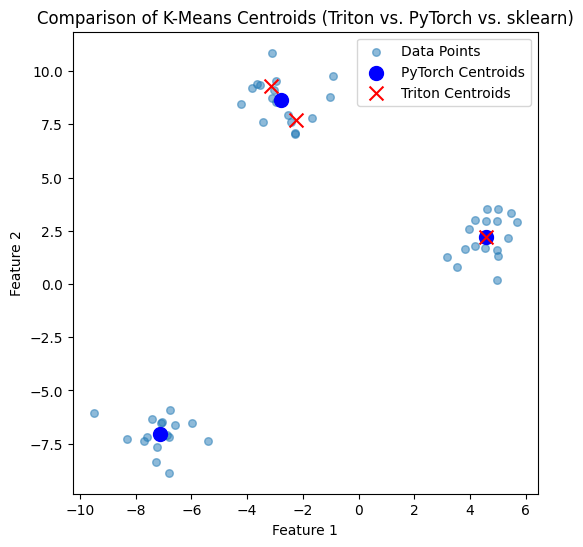

In [61]:
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans

# Generate synthetic dataset with blobs
num_samples = 50
num_features = 2
num_clusters = 3

X_numpy, _ = make_blobs(n_samples=num_samples, centers=num_clusters, n_features=num_features, random_state=42)
X = torch.tensor(X_numpy, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to('cuda')  # Shape (B=1, H=1, L, D)

# Run PyTorch-based k-means
torch.manual_seed(42)
centroids_pytorch, _ = kmeans_pytorch(X, num_clusters, num_iters=8)

# Run Triton-based k-means
torch.manual_seed(42)
centroids_triton, _ = kmeans_triton(X, num_clusters, num_iters=8)

# Run sklearn KMeans
kmeans_sklearn = KMeans(n_clusters=num_clusters, random_state=42, n_init='auto')
kmeans_sklearn.fit(X_numpy)
centroids_sklearn = kmeans_sklearn.cluster_centers_

# Convert to NumPy
centroids_p_numpy = centroids_pytorch[0, 0].cpu().numpy()
centroids_t_numpy = centroids_triton[0, 0].cpu().numpy()

# Scatter plot
plt.figure(figsize=(6, 6))
plt.scatter(X_numpy[:, 0], X_numpy[:, 1], s=30, alpha=0.5, label='Data Points')
plt.scatter(centroids_p_numpy[:, 0], centroids_p_numpy[:, 1], color='blue', marker='o', s=100, label='PyTorch Centroids')
plt.scatter(centroids_t_numpy[:, 0], centroids_t_numpy[:, 1], color='red', marker='x', s=100, label='Triton Centroids')
#plt.scatter(centroids_sklearn[:, 0], centroids_sklearn[:, 1], color='green', marker='s', s=100, label='sklearn Centroids')

plt.legend()
plt.title("Comparison of K-Means Centroids (Triton vs. PyTorch vs. sklearn)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()
